# Face Detection Project: Model Training

This is the training notebook for the Face Detection Project. In this notebook we create a model to detect faces in images. Once created, the model is saved to a file for later use.
The request is to create a sklearn pipeline that includes a feature extractor and a classifier, and return a list of bounding boxes for the detected faces. If no faces are detected, the function should return an empty list.

In [1]:
import process as pc
import dataset as ds
from IPython.core.interactiveshell import InteractiveShell

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib
import cv2
import gc

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

## Data
In order to create the model, we selected two data sources:
- The [Flickr-Faces Dataset (Nvidia) 128x128](https://www.kaggle.com/datasets/dullaz/flickrfaces-dataset-nvidia-128x128) dataset, which contains 70,000 images of faces.
- The [Caltech-101](https://data.caltech.edu/records/mzrjq-6wc02) dataset, which contains 8275 images of 101 classes of objects.<br>

The Caltech dataset is used to create a negative dataset, by cropping random patches from the images. The negative dataset is used to train the model to detect faces in images, in order to avoid false positives, and improve the model's performance.

In [2]:
positive_images_path = ds.DATA_PATH+"/real_faces_128"
negative_images_path = ds.DATA_PATH+"/caltech-101/101_ObjectCategories"

ds.extract_dataset(positive_images_path)
bad_imgs_path_list = ds.extract_dataset(negative_images_path, folder="multi_folders")

Dataset already extracted


One of the requirements provided is that the model should be trained on a system with a reduced computing capacity, the model should require low computational resources, and the training should be done in a reasonable amount of time. For this reason, *we will use a small subset of the data to train the model*.<br>
In particular we will use a dataset of **18000 images from the Flickr-Faces Dataset**, and **20000 images from the Caltech-101 dataset**. Since as we already said, the Clatech-101 dataset has just 8275 images, we needed to augment the quantity of "negative" (negative for our purpose) images. In one of the next steps we will analyse the technique we exploited.<br>
We will also try to adopt some strategies to reduce the amount of memory required by the model, however, **a PC with 32 GB RAM and 2 GB swap may be required to run this notebook**. 

In [3]:
n_good_images = 18000
n_bad_images_folder=1000
size_w = size_h = 96

#count bad images:
bad_img_list = set()
for fld in bad_imgs_path_list:
    tmp_img_list = ds.load_images(negative_images_path+"/"+fld, number_of_images=n_bad_images_folder, random_seed=7)
    for img in tmp_img_list:
        img_path = negative_images_path+"/"+fld+'/'+img
        bad_img_list.add(img_path)

len(bad_img_list)

/home/enrico/Machine_learning/face_detection_project/src/user_warnings.py:4: UserWarning: The requested number of images is greater than the number of images in the folder
  warnings.warn("The requested number of images is greater than the number of images in the folder", UserWarning)


8275

In order to augment the number of negative images, we will use the following technique:
- We will crop random patches from the images in the Caltech-101 dataset, and we will use them as negative samples. We will crop patches of the

In [5]:
bad_patches = ds.extract_patches(bad_img_list, (size_w, size_h), n_patches=20000, random_seed=7)
len(bad_patches)
img_list = ds.load_images(positive_images_path, number_of_images=n_good_images, random_seed=7) 
dataset = np.empty((n_good_images+len(bad_patches), size_w, size_h), dtype=np.uint8)
good_img_len = 0

20000

## Feature Extraction Techniques
We will use the Histogram of Oriented Gradients (HOG) feature extraction technique to extract features from the images. The HOG technique is used to detect objects in images, and is particularly useful for detecting faces. The HOG technique works by dividing the image into small cells, and calculating the gradient of each cell. The gradients are then used to create a histogram of the orientations of the gradients. The histograms are then normalized, and concatenated to create a feature vector for the image.<br>
Other two feature techinques we explored was Scale Invariant Features Transform (SIFT) and Oriented Fast and Rotated Brief (ORB). The SIFT technique is used to detect and describe local features in images, and is particularly useful for object recognition. The ORB technique is used to detect and describe keypoints in images, and is particularly useful for object detection. However, we found that the HOG technique performed better than the other two techniques, and we decided to use it for the model.<br>
Even if they are no more used, the code for the other two techniques is still present in the project, since we think it could be useful for future improvements.

In [4]:
choices = ['HOG', 'SIFT', 'ORB']
print("Choose feature extractor:", flush=True)
for i, choice in enumerate(choices):
    print("{}. {}".format(i+1, choice), flush=True)
#print("%s" %(["%d. %s" %(i+1, choice) for i, choice in enumerate(choices)]), flush=True)

choice_features_extractor = str(input())
choice_features_extractor= choice_features_extractor.upper()
idx = None
while 1:
    if choice_features_extractor == 'HOG':
        idx = choices.index(choice_features_extractor.upper())+1
        break
    elif choice_features_extractor in choices:
        print("Warning: %s not implemented yet. We apologize for the inconvenience." %choice_features_extractor)
    else:
        print("Invalid choice\n")
print("You chose: {}. {}".format(idx, choice_features_extractor.upper()), flush=True)

Choose feature extractor:
1. HOG
2. SIFT
3. ORB
You chose: 1. HOG


In [6]:
for i, img in enumerate(img_list):
    image = cv2.imread(ds.DATA_PATH+"/real_faces_128/"+img)
    dataset[i, ...] = pc.process_image(image, resize=True, img_resize=(size_w, size_h), denoise=True)
    good_img_len += 1

for i, img in zip(range(len(bad_patches)), bad_patches):
    dataset[good_img_len+i, ...] = pc.process_image(img, resize=True, img_resize=(size_w, size_h), denoise=True)

In [7]:
del tmp_img_list, img_list, bad_img_list, bad_patches
gc.collect()

0

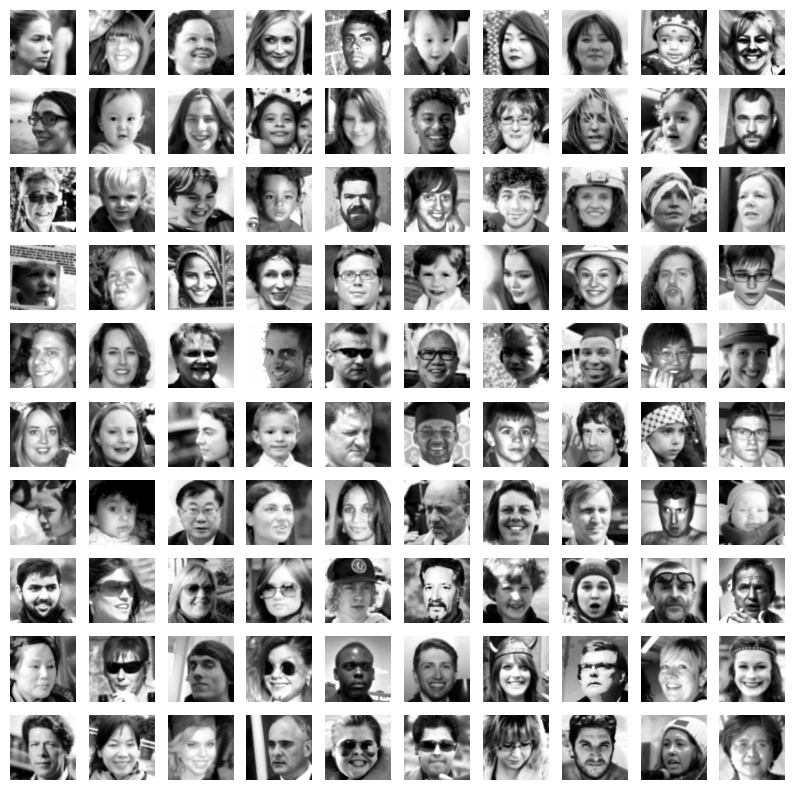

In [8]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(dataset[i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

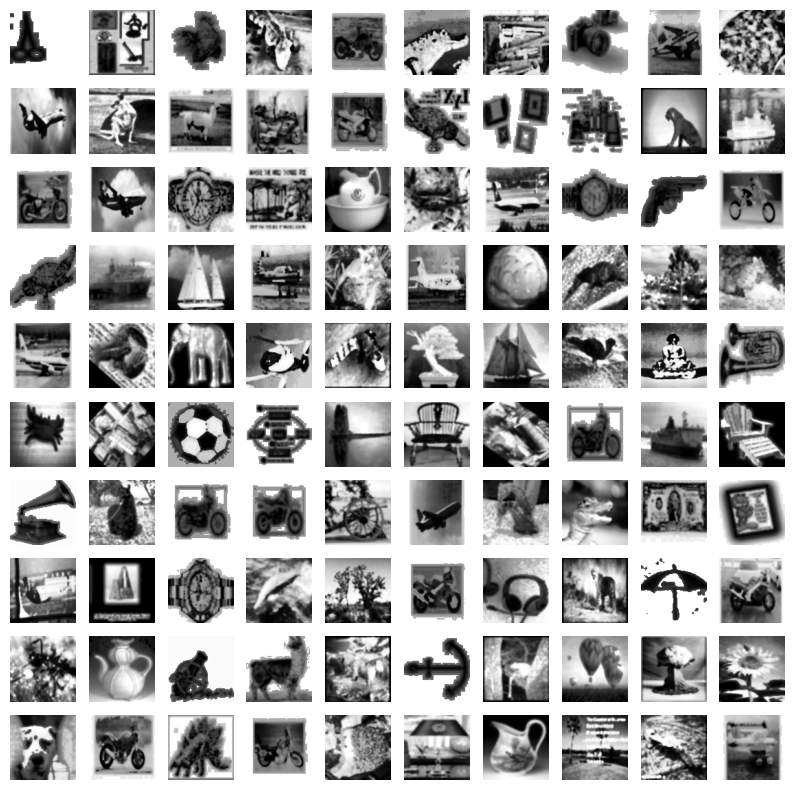

In [9]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(dataset[good_img_len+i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

In [10]:
dataset.shape

(38000, 96, 96)

In [11]:
good_samples = n_good_images
bad_samples = dataset.shape[0] - good_samples
n_keypoints = 32
n_features = 128#256
ftr_shape = n_keypoints*n_features
features = None
X = np.empty((good_samples+bad_samples, 8100), dtype=np.float64)
l = 0

for i, img in enumerate(dataset):
   if choice_features_extractor == "ORB":
      _, features = pc.extract_ORB_features(img, n_keypoints=32)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "SIFT":
      kp, features = pc.extract_SIFT_features(img, n_optimal_keypoints=n_keypoints)
      if len(kp) < n_keypoints:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "HOG":
      ftr_shape = 8100
      features = pc.extract_HOG_features(img)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
      
   features = features.flatten()
   if features.shape[0] == ftr_shape:
      X[l, ...] = features
      l += 1 
   else:
      if i < good_samples:
         features.shape
         print("good sample")
         good_samples -= 1
      else:
         print("bad sample")
         bad_samples -= 1

In [12]:
good_samples
bad_samples
if l < good_samples+bad_samples:
    X = X[:l, ...]
y = np.concatenate((np.ones(good_samples), np.zeros(bad_samples))) 
X.shape
y.shape

18000

20000

(38000, 8100)

(38000,)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=7)

In [14]:
del X, y
gc.collect()

167955

In [15]:
X_train.shape
y_train.shape
X_train[0]
y_train[0]


(34200, 8100)

(34200,)

array([0., 0., 0., ..., 0., 0., 0.])

0.0

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#X = scaler.fit_transform(X)
#X[0]
#X.shape
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
#X_train[0]

In [17]:
param_grid = {  'C' : [np.power(10., i) for i in range(-2, 2)],
                'max_iter' : [5000],
                'random_state' : [7],
                'dual' : ['auto']
             }

grid_searh = GridSearchCV(LinearSVC(), param_grid, cv=7, n_jobs=4)
#grid_searh.fit(X, y)
grid_searh.fit(X_train, y_train)
grid_searh.best_params_

GridSearchCV(cv=7, estimator=LinearSVC(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'dual': ['auto'],
                         'max_iter': [5000], 'random_state': [7]})

{'C': 0.01, 'dual': 'auto', 'max_iter': 5000, 'random_state': 7}

In [18]:
best_svc = grid_searh.best_estimator_
#best_svc.score(X, y)
best_svc.score(X_train, y_train)
best_svc.score(X_test, y_test)

0.9996491228070176

0.998421052631579

In [19]:
y_pred = best_svc.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
#y_pred = best_svc.predict(X)
#accuracy = accuracy_score(y, y_pred)

print("Accuracy train:", accuracy)


y_pred_test = best_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy test:", accuracy)


Accuracy train: 0.9996491228070176
Accuracy test: 0.998421052631579


(1789, 2011)

In [20]:
pipeline_save_path = ds.DATA_PATH+"/hog_new_dataset.pkl"

from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('preprocess', pc.process_image),
        ('normalize', scaler),
        ('extract_features', pc.extract_HOG_features),
        ('svc', best_svc)  
    ])

joblib.dump(
    pipeline, pipeline_save_path
    )

['../data/hog_new_dataset.pkl']